In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
N=40
epsilon = 1

In [3]:
def initgrid(N, seed):
    np.random.seed(seed)
    theta= np.random.rand(N,N)*2*np.pi
    return theta

In [4]:
def neighbours(i,j):
    nbrs= [((i+1) % N,j) , ((i-1) % N , j), (i,(j-1) % N) , (i, (j+1) % N)]
    return nbrs

In [5]:
def Pair_Energy(theta_i,theta_j):
    delta= theta_i - theta_j
    cosd= np.cos(delta)
    P2= 0.5* (3*cosd**2 -1 )
    return -epsilon * P2

In [6]:
def Local_Energy(i,j,theta):
    E=0
    for (ii,jj) in neighbours(i,j):
        E += Pair_Energy(theta[i,j],theta[ii,jj])
    return E

In [7]:
def Whole_Energy (theta):
    E=0
    for i in range(N):
        for j in range(N):
            E += Local_Energy(i,j,theta)
    return 0.5*E
            

In [8]:
def metropolis_step(N,theta,amp,T):
    i= np.random.randint(N)
    j=np.random.randint(N)
    old = Local_Energy(i,j,theta)
    old_angle= theta[i,j].copy()
    delta= (np.random.rand()-0.5)*amp
    theta[i,j]= (theta[i,j]+ delta) % (2*np.pi)
    new = Local_Energy(i,j,theta)
    dE= new - old
    if dE < 0 or np.random.rand()< np.exp(-dE/T):
        return dE, True #accepted
    else:
        theta[i,j]= old_angle
        return dE, False   
    

In [9]:
def Order_Parameter(theta):
    c2= np.cos(2*theta).mean()
    s2= np.sin(2*theta).mean()
    S= np.sqrt(c2**2 + s2**2)
    return S

In [10]:
def probe_equilibration(T, N, max_sweeps=8000, seed=0):
    np.random.seed(seed)
    theta = initgrid(N, seed)
    E_total = Whole_Energy(theta)

    target_low, target_high = 0.30, 0.45
    AMP_MIN, AMP_MAX = 0.05, np.pi
    amp = 0.8

    E_trace, S_trace, acc_trace = [], [], []
    acc = att = 0

    for step in range(max_sweeps * N * N):
        dE, accepted = metropolis_step(N,theta,amp,T)
        att += 1
        if accepted:
            E_total += dE
            acc += 1

        # هر سوییپ
        if (step + 1) % (N * N) == 0:
            rate = acc / max(att, 1)
            # تنظیم آمپ
            if step < (max_sweeps * N * N // 2):
                if rate > target_high: amp *= 1.2
                elif rate < target_low: amp *= 0.8
            else:
                if rate > target_high: amp = min(AMP_MAX, amp * 1.1)
                elif rate < target_low: amp = max(AMP_MIN, amp * 0.9)

            E_trace.append(E_total / (N*N))        # انرژی بر هر سایت
            S_trace.append(Order_Parameter(theta)) # نظم
            acc_trace.append(rate)
            acc = att = 0

    return np.array(E_trace), np.array(S_trace), np.array(acc_trace)


In [11]:
def detect_equil_index(series, window=50, eps_mean=1e-3, eps_slope=1e-4):
    import numpy as np
    x = np.asarray(series)
    if len(x) < window*2: return len(x)-1  # داده کم است

    # میانگین غلتان و شیب خط برازش در پنجره
    def slope(y):
        n = len(y); t = np.arange(n)
        a, b = np.polyfit(t, y, 1)  # y ≈ a t + b
        return a

    for i in range(window, len(x)-window):
        m1 = x[i-window:i].mean()
        m2 = x[i:i+window].mean()
        s2 = slope(x[i:i+window])
        if abs(m2 - m1) < eps_mean and abs(s2) < eps_slope:
            return i  # اولین نقطه‌ای که پایدار شده
    return len(x)-1


Equilibrium reached around sweep 1092 → use equil_sweeps ≈ 1310


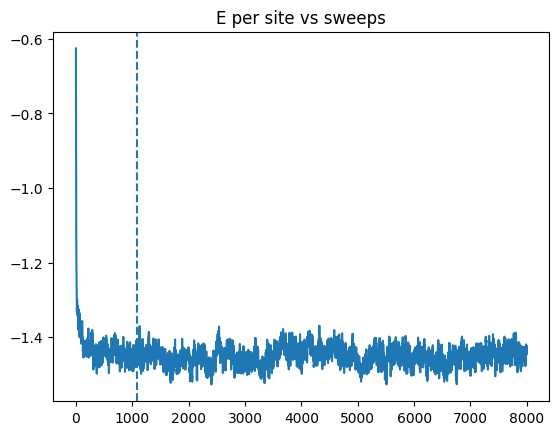

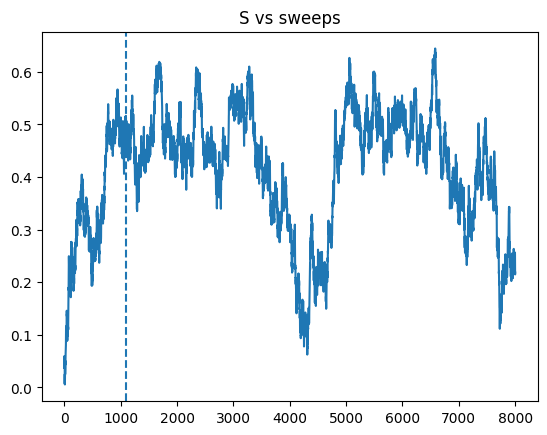

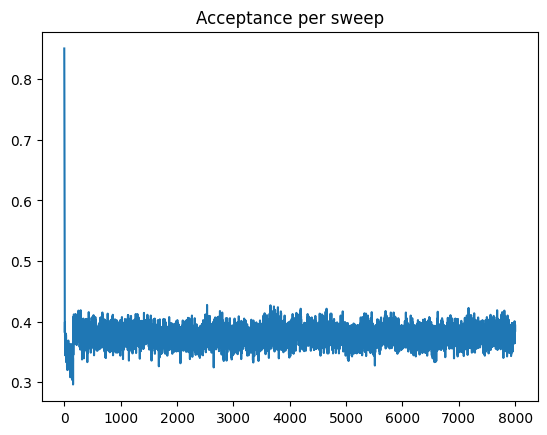

In [12]:
# --- Step 0: Probe equilibration at one temperature to tune equil_sweeps ---
E_tr, S_tr, acc_tr = probe_equilibration(T=0.78, N=40, max_sweeps=8000, seed=42)

idx_E = detect_equil_index(E_tr, window=100)
idx_S = detect_equil_index(S_tr, window=100)
burnin = max(idx_E, idx_S)
equil_sweeps = int(burnin * 1.2)   # add 20% safety margin
print(f"Equilibrium reached around sweep {burnin} → use equil_sweeps ≈ {equil_sweeps}")

# Optional: visualize
plt.plot(E_tr); plt.axvline(burnin, ls='--'); plt.title("E per site vs sweeps"); plt.show()
plt.plot(S_tr); plt.axvline(burnin, ls='--'); plt.title("S vs sweeps"); plt.show()
plt.plot(acc_tr); plt.title("Acceptance per sweep"); plt.show()


In [13]:
def simulate_at_T(T, N, equil_sweeps, prod_sweeps, seed=0):
    np.random.seed(seed)
    theta = initgrid(N, seed=seed)
    E_total = Whole_Energy(theta)

    target_low, target_high = 0.30, 0.45
    amp = 0.8
    acc = 0; att = 0
    rate = 0
    AMP_MIN = 0.05
    AMP_MAX = 5 * np.pi / 4

    # --- Equilibration ---
    for step in trange(equil_sweeps * N * N, desc=f"Equil T={T}", leave=False):
        dE, accepted = metropolis_step(N, theta, amp, T)
        att += 1
        if accepted:
            E_total += dE
            acc += 1

        if (step + 1) % (N * N) == 0:
            rate = acc / max(att, 1)

            if step < (equil_sweeps * N * N // 2):
                if rate > target_high: amp *= 1.2
                elif rate < target_low: amp *= 0.8
            else:
                if rate > target_high: amp = min(AMP_MAX, amp * 1.1)
                elif rate < target_low: amp = max(AMP_MIN, amp * 0.9)

            acc = 0; att = 0

    acc_rate_equil = rate

    # --- Adaptive sampling based on acceptance rate ---
    if acc_rate_equil > 0.6:
        sample_every = 1 * N * N
    elif acc_rate_equil > 0.4:
        sample_every = 2 * N * N
    else:
        sample_every = 3 * N * N

    k = sample_every // (N * N)
    expected = int(prod_sweeps / max(k, 1))

    # --- Production ---
    S_samples = []
    Energy_samples = []
    acc = 0; att = 0
    for step in trange(prod_sweeps * N * N, desc=f"Prod T={T}", leave=False):
        dE, accepted = metropolis_step(N, theta, amp, T)
        att += 1
        if accepted:
            E_total += dE
            acc += 1

        if (step + 1) % sample_every == 0:
            S_samples.append(Order_Parameter(theta))
            Energy_samples.append(E_total)

    acc_rate = acc / max(att, 1)

    # --- Statistics ---
    S_samples = np.array(S_samples)
    E_arr = np.array(Energy_samples)

    S_mean = np.mean(S_samples)
    varS = np.var(S_samples, ddof=1)
    chi = (N * N) * varS / T

    varE = np.var(Energy_samples, ddof=1)
    capacity = varE / ((N * N) * T * T)

    S_sem = S_samples.std(ddof=1) / np.sqrt(len(S_samples))

    return S_mean, S_sem, acc_rate, amp, chi, capacity, S_samples, Energy_samples, acc_rate_equil, k, expected


In [14]:
# --- Quick test for simulate_at_T ---
T_test = 0.80
N = 40
equil_sweeps = 1600   # همون مقداری که از probe_equilibration گرفتی
prod_sweeps = 5000    # برای تست کوتاه، نصف مقدار اصلی
seed = 42

print(f"\nRunning quick test at T={T_test} ...")
res = simulate_at_T(T_test, N, equil_sweeps, prod_sweeps, seed)

(S_mean, S_sem, acc_rate, amp, chi, capacity, S_samples, Energy_samples, acc_rate_equil, k, expected) = res

print(f"\n✅ Test finished at T={T_test}")
print(f"S_mean = {S_mean:.3f} ± {S_sem:.3f}")
print(f"acc_rate_equil = {acc_rate_equil:.3f}")
print(f"acc_rate_prod  = {acc_rate:.3f}")
print(f"amp = {amp:.3f}")
print(f"sample_every = {k} sweeps | expected_samples ≈ {expected}")
print(f"Actual samples: {len(S_samples)} , {len(Energy_samples)}")



Running quick test at T=0.8 ...



✅ Test finished at T=0.8
S_mean = 0.240 ± 0.003
acc_rate_equil = 0.367
acc_rate_prod  = 0.392
amp = 2.752
sample_every = 3 sweeps | expected_samples ≈ 1666
Actual samples: 1666 , 1666


In [15]:
# --- Step 2: Full temperature scan ---
T_list = np.linspace(0.74, 0.90, 9)   # از 0.74 تا 0.90 با گام 0.02
N = 40
equil_sweeps = 1600
prod_sweeps = 10000
seed = 42

S_means, S_errs, acc_rates, amps, chis, capacities,expected_samples = [], [], [], [], [], [],[]
results_S40 = {}
results_E40 = {}



In [16]:
for T in T_list:
    print(f"\nRunning simulation at T={T:.3f} ...")
    S_mean, S_sem, acc_rate, amp, chi, capacity, S_samples, Energy_samples, acc_rate_equil, k, expected = simulate_at_T(
        T, N, equil_sweeps, prod_sweeps, seed)
    
    S_means.append(S_mean)
    S_errs.append(S_sem)
    acc_rates.append(acc_rate)
    amps.append(amp)
    chis.append(chi)
    capacities.append(capacity)
    expected_samples.append(expected)
    
    results_S40[T] = S_samples
    results_E40[T] = Energy_samples

    print(f"T={T:.3f} | acc_equil≈{acc_rate_equil:.3f} | sample_every={k} sweeps | expected≈{expected}")
    print(f"Actual: {len(S_samples)} , {len(Energy_samples)}")



Running simulation at T=0.740 ...


T=0.740 | acc_equil≈0.352 | sample_every=3 sweeps | expected≈3333
Actual: 3333 , 3333

Running simulation at T=0.760 ...


T=0.760 | acc_equil≈0.333 | sample_every=3 sweeps | expected≈3333
Actual: 3333 , 3333

Running simulation at T=0.780 ...


T=0.780 | acc_equil≈0.378 | sample_every=3 sweeps | expected≈3333
Actual: 3333 , 3333

Running simulation at T=0.800 ...


T=0.800 | acc_equil≈0.367 | sample_every=3 sweeps | expected≈3333
Actual: 3333 , 3333

Running simulation at T=0.820 ...


T=0.820 | acc_equil≈0.362 | sample_every=3 sweeps | expected≈3333
Actual: 3333 , 3333

Running simulation at T=0.840 ...


T=0.840 | acc_equil≈0.384 | sample_every=3 sweeps | expected≈3333
Actual: 3333 , 3333

Running simulation at T=0.860 ...


T=0.860 | acc_equil≈0.386 | sample_every=3 sweeps | expected≈3333
Actual: 3333 , 3333

Running simulation at T=0.880 ...


T=0.880 | acc_equil≈0.366 | sample_every=3 sweeps | expected≈3333
Actual: 3333 , 3333

Running simulation at T=0.900 ...


T=0.900 | acc_equil≈0.385 | sample_every=3 sweeps | expected≈3333
Actual: 3333 , 3333


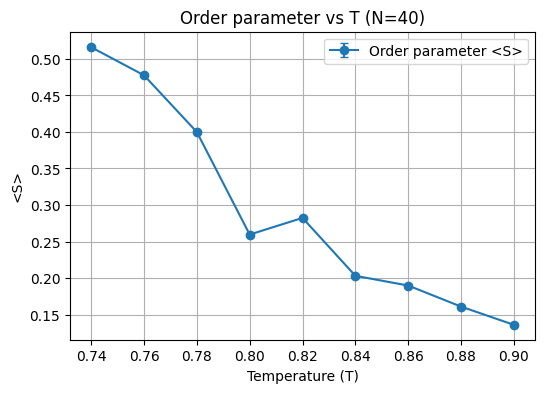

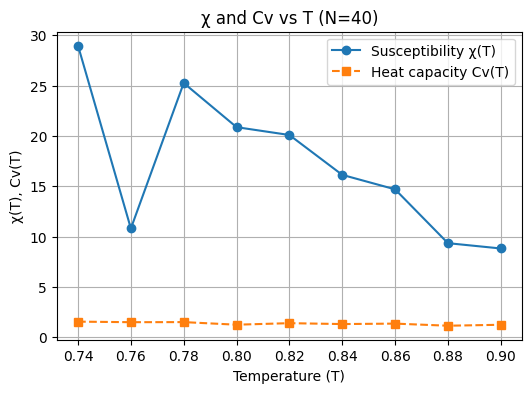

In [17]:
# --- Plot 1: Order Parameter ---
plt.figure(figsize=(6,4))
plt.errorbar(T_list, S_means, yerr=S_errs, fmt='-o', capsize=3, label='Order parameter <S>')
plt.xlabel('Temperature (T)')
plt.ylabel('<S>')
plt.title(f'Order parameter vs T (N={N})')
plt.grid(True)
plt.legend()
plt.show()

# --- Plot 2: Susceptibility χ(T) and Heat Capacity Cv(T) ---
plt.figure(figsize=(6,4))
plt.plot(T_list, chis, 'o-', label='Susceptibility χ(T)')
plt.plot(T_list, capacities, 's--', label='Heat capacity Cv(T)')
plt.xlabel('Temperature (T)')
plt.ylabel('χ(T), Cv(T)')
plt.title(f'χ and Cv vs T (N={N})')
plt.grid(True)
plt.legend()
plt.show()

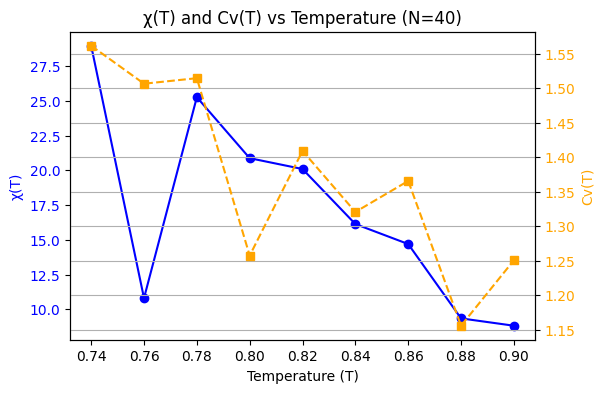

In [27]:
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(T_list, chis, 'o-', color='blue', label='Susceptibility χ(T)')
ax1.set_xlabel('Temperature (T)')
ax1.set_ylabel('χ(T)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(T_list, capacities, 's--', color='orange', label='Heat capacity Cv(T)')
ax2.set_ylabel('Cv(T)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title(f'χ(T) and Cv(T) vs Temperature (N={N})')
plt.grid(True)
plt.show()


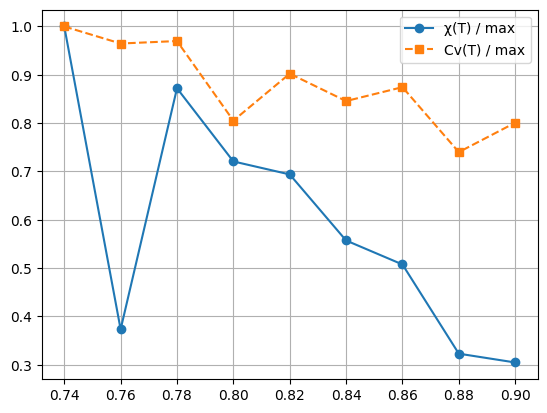

In [28]:
plt.plot(T_list, chis/np.max(chis), 'o-', label='χ(T) / max')
plt.plot(T_list, capacities/np.max(capacities), 's--', label='Cv(T) / max')
plt.legend(); plt.grid(True)


In [24]:
from scipy.optimize import curve_fit

# --- Quadratic fitting function ---
def quad(x, a, b, c):
    return a*x**2 + b*x + c

def quad_peak_T(T_list, y_values):
    """Finds the peak position (Tc) by fitting a quadratic curve near the maximum."""
    i_peak = np.argmax(y_values)
    i1 = max(0, i_peak-2)
    i2 = min(len(T_list), i_peak+3)
    T_fit = np.array(T_list[i1:i2])
    y_fit = np.array(y_values[i1:i2])

    if len(T_fit) < 3:
        return np.nan  # need ≥3 points for fitting

    popt, _ = curve_fit(quad, T_fit, y_fit)
    a, b, c = popt
    Tc_fit = -b / (2*a)
    return Tc_fit


In [25]:
# --- find fitted Tc values ---
Tc_chi_fit = quad_peak_T(T_list, chis)
Tc_cv_fit  = quad_peak_T(T_list, capacities)

Tc_est = 0.5 * (Tc_chi_fit + Tc_cv_fit)

print(f"Tc (χ-fit) = {Tc_chi_fit:.3f}")
print(f"Tc (Cv-fit) = {Tc_cv_fit:.3f}")
print(f"→ Estimated Tc ≈ {Tc_est:.3f}")

Tc (χ-fit) = 0.761
Tc (Cv-fit) = 0.767
→ Estimated Tc ≈ 0.764


In [23]:
Tc_est = 0.5 * (Tc_chi + Tc_cv)
print("Estimated Tc ≈", Tc_est)

Estimated Tc ≈ 0.764297795888235


In [ ]:
print(T, len(S_samples), len(Energy_samples))


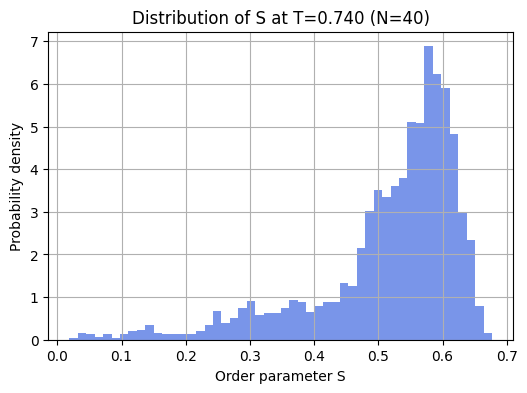

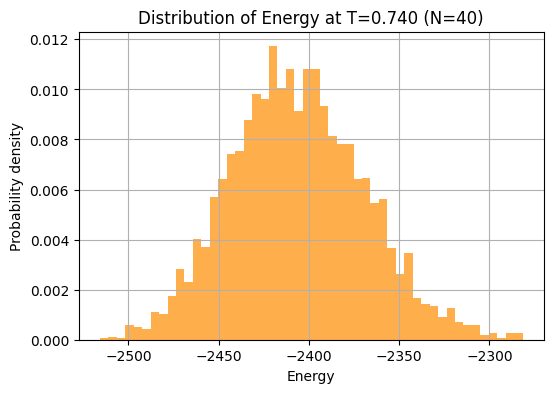

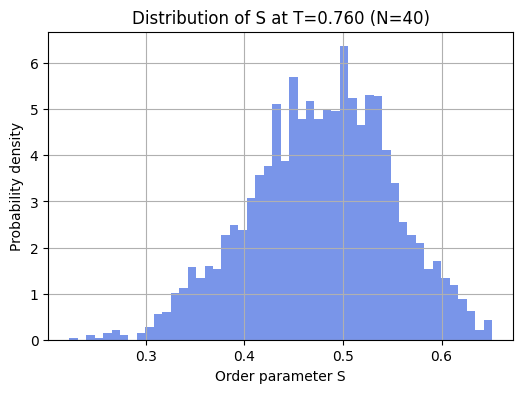

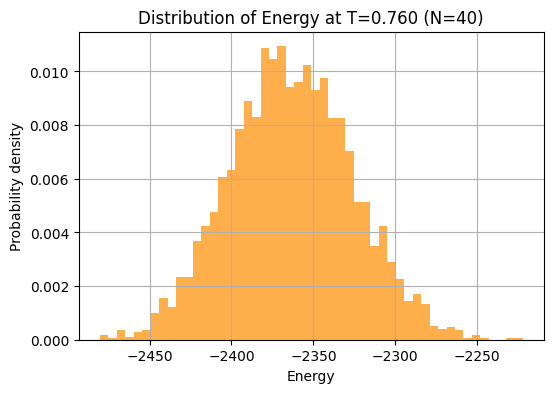

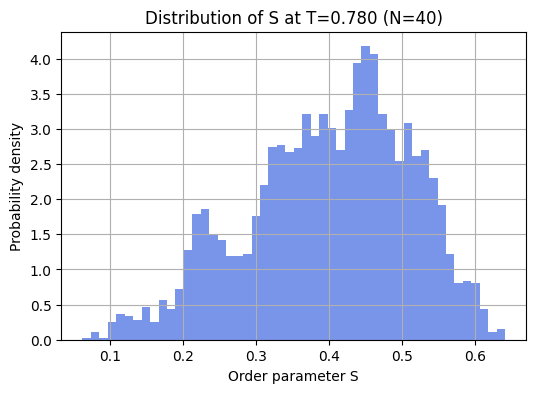

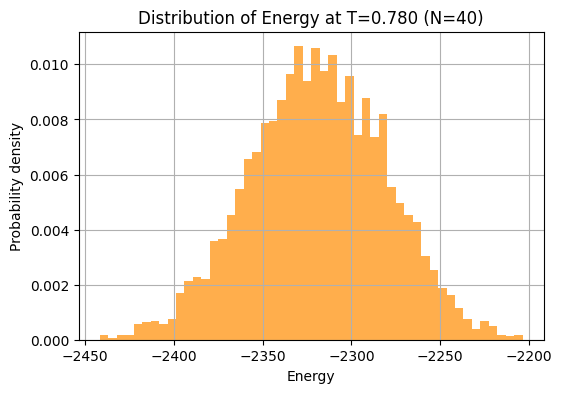

In [29]:
# Example: visualize near critical region
Tc_est = 0.764  # your estimated critical temp
T_near = [0.74, 0.76, 0.78]  # around Tc

for T in T_near:
    plt.figure(figsize=(6,4))
    plt.hist(results_S40[T], bins=50, density=True, alpha=0.7, color='royalblue')
    plt.xlabel('Order parameter S')
    plt.ylabel('Probability density')
    plt.title(f'Distribution of S at T={T:.3f} (N={N})')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.hist(results_E40[T], bins=50, density=True, alpha=0.7, color='darkorange')
    plt.xlabel('Energy')
    plt.ylabel('Probability density')
    plt.title(f'Distribution of Energy at T={T:.3f} (N={N})')
    plt.grid(True)
    plt.show()
